# 3. 각 Layer 별 역할 개념 및 파라미터 파악

### 예제 불러오기

In [1]:
import torch
from torchvision import datasets, transforms

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset', train = True , download = True,
                  transform = transforms.Compose([
                      transforms.ToTensor()
                  ])),
    batch_size = 1 )

In [3]:
image , label = next(iter(train_loader))

In [4]:
image.shape, label.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

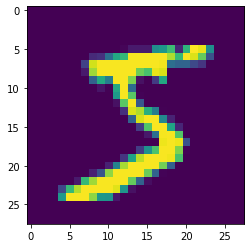

In [5]:
plt.imshow(image[0,0,:,:])
plt.show()

### 각 layer 별 설명 
- network 쌓기 위한 준비

In [6]:
import torch
import torch.nn as nn  # 안에 weight 가 있는것 
import torch.nn.functional as F # weight 가 없는 것 

### Convolution
- in_channels : 받게 될 channel 의 갯수
- out_channels : 보내고 싶은 channel의 갯수
- kernel_size : 만들고 싶은 kenel(weights)사이즈

In [7]:
# tensorflow 는 out channel 만 지정해주지만, 여기선 in, out 둘다 사용 .
# 이미지 커널 사이즈를   5x5 로 
nn.Conv2d(in_channels  = 1, out_channels  = 20, kernel_size= 5, stride= 1)

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [8]:
layer = nn.Conv2d(1, 20 , 5, 1).to(torch.device('cpu'))
layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

- weight 시각화를 위해 slice 하고 numpy 화

In [9]:
weight = layer.weight
weight.shape


torch.Size([20, 1, 5, 5])

In [10]:
type(weight)

torch.nn.parameter.Parameter

- 여기서 weight는 학습 가능한 상태이기 때문에 바로 Numpy를 뽑아낼 수 있음
- detach() method는 그래프에서 잠깐 빼서 gradient에 영향을 받지 않게 함 

In [11]:
weight = weight.detach().numpy() # 살짝 꺼내줘야 numpy를 만들 수 있음. 안그러면 오류가 남. 

In [12]:
type(weight)

numpy.ndarray

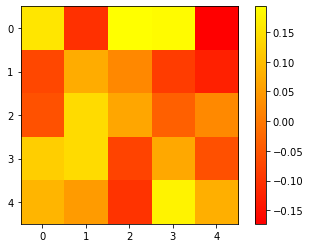

In [13]:
plt.imshow(weight[0,0, :,:], 'autumn') # autumn 은 색이므로, 알아서 변환 가능 
plt.colorbar()
plt.show()

- output 시각화 준비를 위해 numpy 화

In [14]:
output_data = layer(image)
print(type(output_data))
output_data = output_data.data  # .data 를 해줘야 볼수 있게 됨
output = output_data.cpu().numpy()
print(type(output))
print(output.shape)

<class 'torch.Tensor'>
<class 'numpy.ndarray'>
(1, 20, 24, 24)


- input으로 들어간 이미지 numpy 화

In [15]:
image_arr = image.numpy()
image_arr.shape

(1, 1, 28, 28)

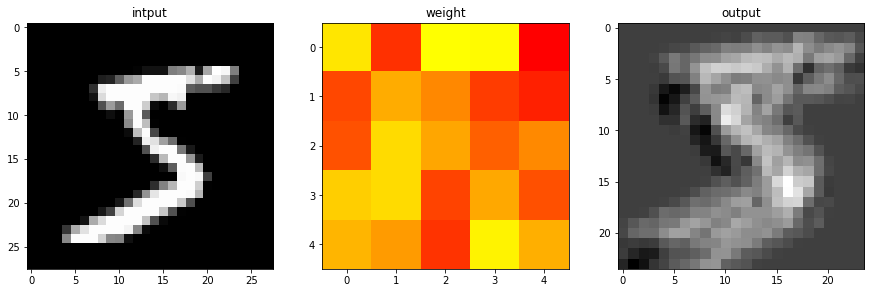

In [16]:
plt.figure(figsize = (15,30))
plt.subplot(131)
plt.title('intput')
plt.imshow(np.squeeze(image_arr), 'gray')  #지금 shape 에 1이 있기 때문에 squeeze를 해줘야함
plt.subplot(132)
plt.title('weight')
plt.imshow(weight[0,0, :,:], 'autumn')
plt.subplot(133)
plt.title('output')
plt.imshow(output[0,0,:,:], 'gray')
plt.show()

### Pooling 
input 먼저 앞에 넣고, 뒤에 kernel 사이즈와 stride를 순서대로 넣는다


In [17]:
image.shape

torch.Size([1, 1, 28, 28])

In [18]:
pool = F.max_pool2d(image, 2,2 )
pool.shape

torch.Size([1, 1, 14, 14])

 - MaxPool Layer 는 weight 가 없기 대문에 바로 numpy() 가 가능 

In [19]:
pool_arr = pool.numpy()
pool_arr.shape

(1, 1, 14, 14)

In [20]:
image_arr.shape

(1, 1, 28, 28)

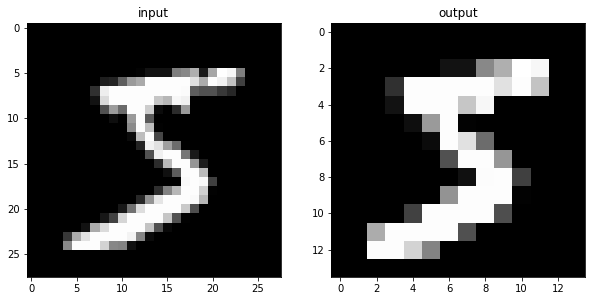

In [21]:
plt.figure(figsize = (10,15))
plt.subplot(121)
plt.title('input')
plt.imshow(np.squeeze(image_arr) , 'gray') # 역시 앞의 1 을 없애기 위해 squeeze를 사용
plt.subplot(122)
plt.title('output')
plt.imshow(np.squeeze(pool_arr) , 'gray') 
plt.show()

>  반 줄어들면서 , 결과가 오른쪽 처럼 됨

### Linear
nn.Linear 는 2d가 아닌 1d 만 들어가기 때문에, .view() 1D로 펼쳐줘야함
- flat 을 해주는 아이가 없기 때문에, reshape 나 view를 이용해줌

In [22]:
image.shape

torch.Size([1, 1, 28, 28])

In [23]:
flatten = image.view(1, 28 * 28) # 배치 사이즈는 그대로 유지해줘야하기 때문에 , 1 르르 남겨줌 
flatten.shape

torch.Size([1, 784])

In [24]:
lin = nn.Linear(784, 10 )(flatten) # 784 를 받고 10개를 내보낸다.
lin.shape

torch.Size([1, 10])

In [25]:
lin

tensor([[-3.7594e-01, -4.3352e-01, -2.9133e-01, -1.8678e-01,  7.0356e-02,
          3.1030e-01, -1.1380e-01,  2.4199e-04, -1.3257e-01, -2.3744e-01]],
       grad_fn=<AddmmBackward>)

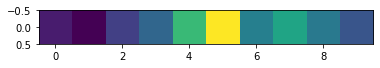

In [26]:
plt.imshow(lin.detach().numpy()) # lin에는 weight 가 존재하기 때문에, detach를 해줘야한다. 
plt.show()

### Softmax
결과를 numpy 로 꺼내기 위해선 weight가 담긴 Linear에 weight를 껴줘야함

In [27]:
with torch.no_grad():  # weight 를 완전히 무시
    flatten = image.view(1, 28*28)
    lin = nn.Linear(784,10)(flatten)
    softmax = F.softmax(lin , dim =1)  # 뒤에있는 10을  소프트 맥스하려는 것이기 때문에, dim =1 로 지정 
    # weight 에 비해 간단하게 숫자가 나온것을 확인 할 수 있다. 

In [28]:
softmax

tensor([[0.0849, 0.0885, 0.0696, 0.1311, 0.1139, 0.0820, 0.1071, 0.0833, 0.1565,
         0.0832]])

In [29]:
np.sum(softmax.numpy())

1.0

### Layer 쌓기
nn 과  nn.functional 의 차이점
- nn은 학습 파라미터가 담긴것
- nn.functional 은 학습 파라미터가 없는 것이라고 생각하면 간단

In [34]:
# 항상 똑같이 쌓으므로, class 를 같다 붙여넣기 하면 된다고 함 ^^ 
class Net(nn.Module)  : # 모듈을 담는다
        def __init__(self):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(1,20,5,1)  # in_channels  = 1, out_channels  = 20, kernel_size= 5, stride= 1
            self.conv2 = nn.Conv2d(20, 50, 5 ,1 )
            self.fc1 = nn.Linear(4 *4*50 , 500)  #fully Connected layer 
            self.fc2 = nn.Linear(500, 10)
            
        def forward(self, x):
            # feature extraction
            x = F.relu(self.conv1(x)) # 컨벌루션이 relu를 거침
            x = F.max_pool2d(x, 2,2)
            x = F.relu(self.conv2(x))
            x = F.max_pool2d(x, 2,2)
            
            # fully connecte ( classificiation )
#             print(x.shape)
            x = x.view(-1, 4 *4*50) # 펼쳐줘야하는데, 배치사이즈를 얼마나 받아줘야하는지 몰라서 -1 로 둠
            # 뒤에 4*4*50 이 나온 이유는 ,model = Net()
            # model.forward(image) # torch.Size([1, 50, 4, 4]) 이 나오기 때문이다. 
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            return F.log_softmax(x, dim  =  1 )

In [35]:
model = Net()
model.forward(image) # torch.Size([1, 50, 4, 4])

tensor([[-2.2821, -2.2665, -2.2930, -2.2945, -2.3300, -2.2510, -2.2912, -2.3870,
         -2.3658, -2.2732]], grad_fn=<LogSoftmaxBackward>)

In [36]:
model.conv1 # 안에서 구현한 것들을 볼 수 있음 

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))